In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
# from __future__ import print_function
# from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

from Autoencoder_Utils import print_features_histograms, plot_difference_displ, print_features_histograms_displ

# plt.rc('text', usetex=False)
%matplotlib inline

Using TensorFlow backend.


In [2]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '0'

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

tf.set_random_seed(1)
sess = tf.Session(config=config)
set_session(sess)

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

# Считаем подготовленные для обучения автоэнкодера данные

In [3]:
# Loading the data
TYPE = "" # 100% of the data. To determine the real performance of the cross check
# TYPE = "_10perc" # 10% of the data. Used for everything except to determine the real performance of the cross check
# TYPE = "_1perc" # 1% of the data. For small tests.
# TYPE = "_100" # 100 samples of the data. For very rudimentary tests

df = pd.read_csv('../LHCb_PID_Compression_Generate_Data/LHCb_PID_obscured_9.csv')

In [4]:
df.head()

,pid,S5aux0,S3aux0,S2aux0,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,...,S4x1,S4x2,S3x2,S4x3,S4x4,S5x1,S5x2,S5x3,S5x4,S4x5
0,c,1.0,1.0,1.0,5.247528,16.0,8.471252,9.0,1.0,1.0,...,-999.0,-999.0,0.000000,-999.000000,-999.000000,0.990941,1442.369995,39709.0,1.0,-999.000000
1,b,1.0,1.0,-999.0,13.196465,18.0,5.999196,13.0,-999.0,-999.0,...,35070.0,1.0,1074.202026,2.687757,1.079463,0.990941,1442.369995,39709.0,1.0,12.509591
2,a,-999.0,1.0,1.0,15.906058,7.0,1.595535,3.0,0.0,0.0,...,34829.0,1.0,1837.494019,3165.065918,0.241262,-999.000000,-999.000000,-999.0,-999.0,-25385.501953
3,a,1.0,1.0,-999.0,14.878747,18.0,4.440444,5.0,-999.0,-999.0,...,-999.0,-999.0,0.000000,-999.000000,-999.000000,1.001928,996.435974,34159.0,0.0,-999.000000
4,d,1.0,1.0,1.0,8.652092,15.0,2.004206,2.0,0.0,0.0,...,38403.0,1.0,2504.743896,3.648586,0.899063,0.764151,2988.066650,42332.0,1.0,38.088371


In [5]:
df = df[df["pid"] != 'c']

In [6]:
# How many samples of each particle do we have
print(df['pid'].value_counts())

d    3239565
b    2964364
f    2873158
a    2842878
e    2823096
Name: pid, dtype: int64


In [7]:
pids_no = df['pid'].value_counts().to_dict()
n_samples = np.shape(df.as_matrix())[0]

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [8]:
# Dividing the variables into compressable, auxiliary and simulation truth variables not seen in real datasets
vars_list = list(df)
vars_list_input, vars_list_aux, vars_list_MC = [], [], []

for v in vars_list:
    if v == 'pid': 
        vars_list_MC.append(v)
    elif 'aux' in v: 
        vars_list_aux.append(v)
    else: 
        vars_list_input.append(v)

print("{} variables to compress".format(len(vars_list_input)))

35 variables to compress


/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


CPU times: user 35.5 s, sys: 10.7 s, total: 46.2 s
Wall time: 39.2 s


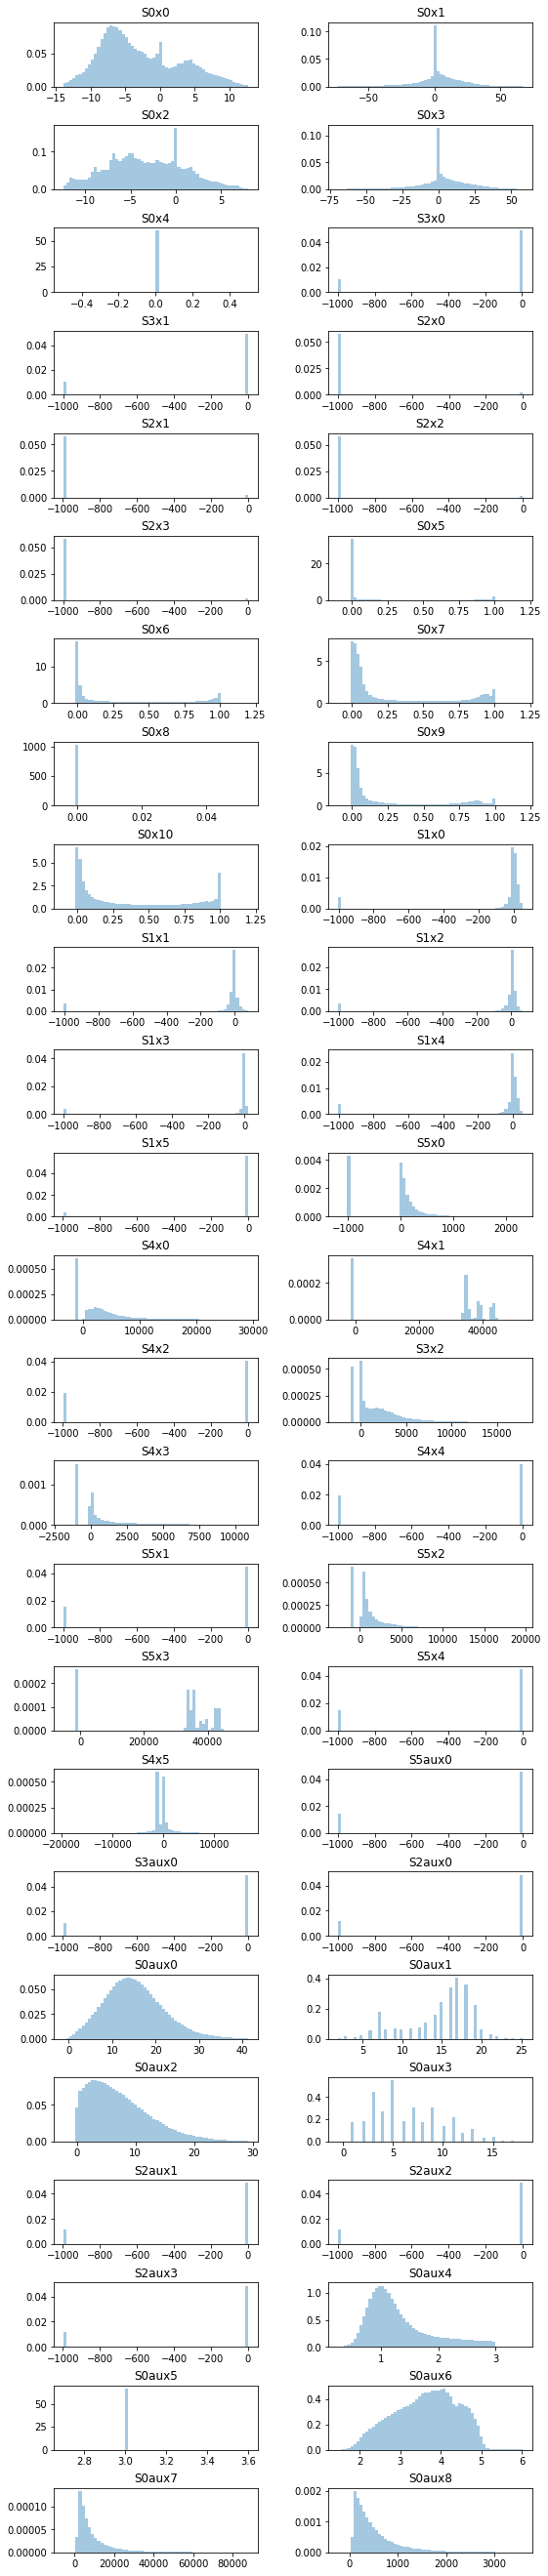

In [9]:
%%time
# Display histograms of our features
print_features_histograms(df[vars_list_input + vars_list_aux], None, save_filename="./img/original_distribs.png")

# Разобъем индексы на train и test

In [10]:
# train test split
train_size = 0.1
test_size = 0.9
idx_train, idx_test = train_test_split(np.arange(df.shape[0], dtype='int32'), random_state=5,
                                       stratify=df['pid'], train_size=train_size, test_size=test_size)

In [11]:
df.shape, idx_train.shape, idx_test.shape

((14743061, 51), (1474306,), (13268755,))

## Переведем значения признаков в отрезок $[-1, 1]$

Ранее помимо масштабирования признаков меняли и их распределение на равномерное, но это не имеет смысла, так как энкодер и декодер восстанавливают распределения $P(Z|X)$ и $Q(X|Z)$ соответственно. А по ним уже восстанавливается распределение $P(X)$ каким бы оно не было.

##### Так то оно правильно, но, может быть, автоэнкодеру проще восстановить равномерное распределение, чем произвольное?!

In [12]:
df_scaled = df.copy()

In [13]:
%%time
scalers = {}

for var in (vars_list_input + vars_list_aux):
    # normalize with StandardScaler
    std_scaler = StandardScaler()
    std_scaler.fit(df[var].iloc[idx_train].values.reshape(-1, 1))
    df_scaled[var] = std_scaler.transform(df[var].values.reshape(-1, 1))
    
    # normalize with MaxAbsScaler
    max_scaler = MaxAbsScaler()
    max_scaler.fit(df_scaled[var].iloc[idx_train].values.reshape(-1, 1))
    df_scaled[var] = max_scaler.transform(df_scaled[var].values.reshape(-1, 1))
    scalers[var] = {
        'std': std_scaler,
        'max': max_scaler
    }

CPU times: user 25 s, sys: 2.72 s, total: 27.7 s
Wall time: 27.8 s


/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


CPU times: user 33.2 s, sys: 8.3 s, total: 41.5 s
Wall time: 34.8 s


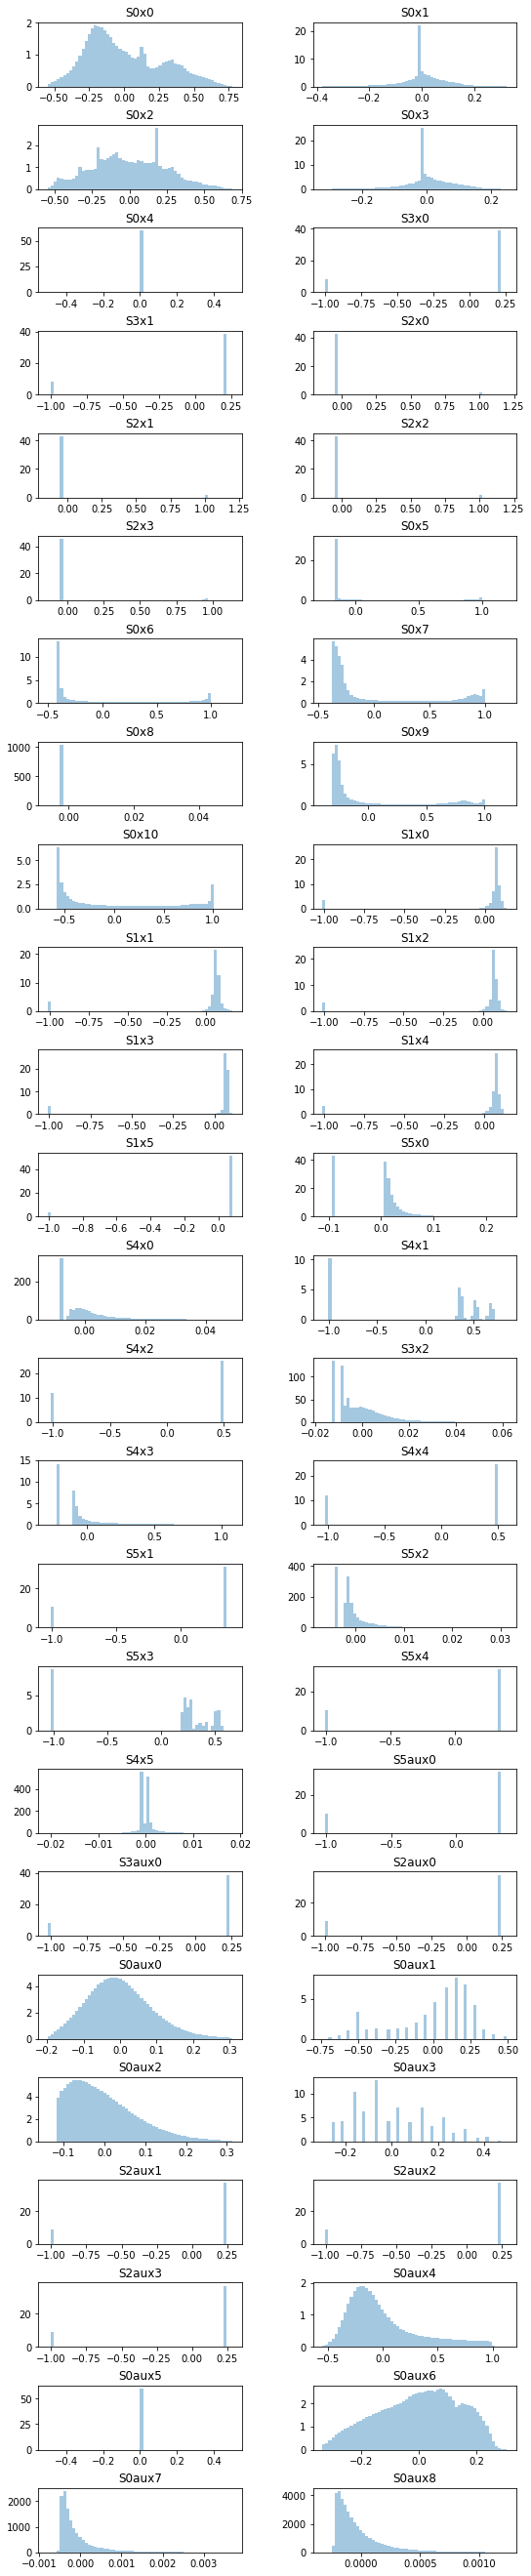

In [14]:
%%time
# Display histograms of our features
print_features_histograms(df_scaled[vars_list_input + vars_list_aux], None, save_filename="./img/scaled_distribs.png")

## Зададим архитектуру автоэнкодера

In [15]:
def create_autoencoder_aux(n_features, encoding_dim, n_aux_features=5, p_drop=0.5, n_layers=3, thickness=2):
    # Энкодер
    inputs = Input(shape=(n_features, ), name='main_input')
    aux_inputs = Input(shape=(n_aux_features, ), name='aux_inputs')
    
    
    x = keras.layers.concatenate([inputs, aux_inputs])

    for i in range(n_layers - 1):
        x = Dense(thickness * n_features, activation='tanh')(x)
        x = keras.layers.concatenate([x, aux_inputs])

#     x = Dropout(p_drop)(x)
    
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
    x = keras.layers.concatenate([x, aux_inputs])
#     x = Dropout(p_drop)(x)
    encoded = Dense(encoding_dim, activation='tanh', name='encoded')(x)

    
    # Декодер
    input_encoded = Input(shape=(encoding_dim, ))
    
    x = keras.layers.concatenate([input_encoded, aux_inputs])
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
#     x = Dropout(p_drop)(x)
    
    for i in range(n_layers - 1):
        x = keras.layers.concatenate([x, aux_inputs])
        x = Dense(thickness * n_features, activation='tanh')(x)
        
#     x = Dropout(p_drop)(x)
    decoded = Dense(n_features, activation='tanh')(x)
    
    
    # Модели
    encoder = Model([inputs, aux_inputs], encoded, name="encoder")
    decoder = Model([input_encoded, aux_inputs], decoded, name="decoder")
    autoencoder = Model(
        [inputs, aux_inputs], decoder([encoder([inputs, aux_inputs]), aux_inputs]), name="autoencoder"
    )

    optimizer_adam = optimizers.Adam(lr=0.001)
    autoencoder.compile(loss='mse', optimizer=optimizer_adam)
    
    return autoencoder, encoder, decoder

## Обучим автоэнкодер

In [16]:
l_encoding_dim = [3, 6, 9]
l_score = []
val_size = 0.1

train = df_scaled.iloc[idx_train]
test = df_scaled.iloc[idx_test]

train_input = train[vars_list_input].values
train_aux   = train[vars_list_aux].values
train_MC    = train[vars_list_MC].values

test_input = test[vars_list_input].values
test_aux   = test[vars_list_aux].values
test_MC    = test[vars_list_MC].values

  0%|          | 0/3 [00:00<?, ?it/s]

encoding_dim :  3
Train on 1326875 samples, validate on 147431 samples
Epoch 1/30
1326875/1326875 [==============================] - 84s 63us/step - loss: 0.0054 - val_loss: 0.0022
Epoch 2/30
1326875/1326875 [==============================] - 84s 63us/step - loss: 0.0020 - val_loss: 0.0019
Epoch 3/30
1326875/1326875 [==============================] - 82s 62us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/30
1326875/1326875 [==============================] - 82s 61us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/30
1326875/1326875 [==============================] - 82s 62us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/30
1326875/1326875 [==============================] - 83s 62us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/30
1326875/1326875 [==============================] - 83s 62us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/30
1326875/1326875 [==============================] - 81s 61us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/30
1326875/1326875 [=====================

 33%|███▎      | 1/3 [38:44<1:17:29, 2324.72s/it]




encoding_dim :  6
Train on 1326875 samples, validate on 147431 samples
Epoch 1/30
1326875/1326875 [==============================] - 77s 58us/step - loss: 0.0028 - val_loss: 9.0717e-04
Epoch 2/30
1326875/1326875 [==============================] - 77s 58us/step - loss: 7.6562e-04 - val_loss: 6.9542e-04
Epoch 3/30
1326875/1326875 [==============================] - 77s 58us/step - loss: 6.2585e-04 - val_loss: 6.1470e-04
Epoch 4/30
1326875/1326875 [==============================] - 77s 58us/step - loss: 5.4880e-04 - val_loss: 5.8597e-04
Epoch 5/30
1326875/1326875 [==============================] - 78s 59us/step - loss: 4.7845e-04 - val_loss: 5.0367e-04
Epoch 6/30
1326875/1326875 [==============================] - 77s 58us/step - loss: 4.5810e-04 - val_loss: 4.7092e-04
Epoch 7/30
1326875/1326875 [==============================] - 78s 59us/step - loss: 4.4001e-04 - val_loss: 3.9500e-04
Epoch 8/30
1326875/1326875 [==============================] - 77s 58us/step - loss: 3.6809e-04 - val_los

 67%|██████▋   | 2/3 [1:28:04<44:02, 2642.03s/it]




encoding_dim :  9
Train on 1326875 samples, validate on 147431 samples
Epoch 1/30
1326875/1326875 [==============================] - 129s 98us/step - loss: 0.0012 - val_loss: 5.8297e-04
Epoch 2/30
1326875/1326875 [==============================] - 128s 97us/step - loss: 3.9302e-04 - val_loss: 2.9106e-04
Epoch 3/30
1326875/1326875 [==============================] - 128s 96us/step - loss: 2.1077e-04 - val_loss: 1.8813e-04
Epoch 4/30
1326875/1326875 [==============================] - 127s 96us/step - loss: 1.5673e-04 - val_loss: 1.5163e-04
Epoch 5/30
1326875/1326875 [==============================] - 127s 96us/step - loss: 1.5190e-04 - val_loss: 1.3199e-04
Epoch 6/30
1326875/1326875 [==============================] - 128s 96us/step - loss: 1.1213e-04 - val_loss: 1.0633e-04
Epoch 7/30
1326875/1326875 [==============================] - 129s 97us/step - loss: 1.5473e-04 - val_loss: 1.1531e-04
Epoch 8/30
1326875/1326875 [==============================] - 129s 97us/step - loss: 1.4575e-04 -

100%|██████████| 3/3 [2:14:50<00:00, 2696.88s/it]




CPU times: user 2h 32min 28s, sys: 37min 43s, total: 3h 10min 12s
Wall time: 2h 14min 55s


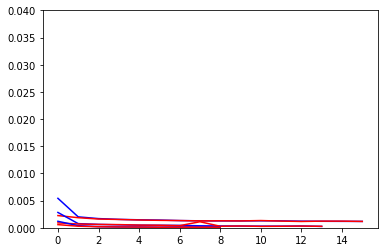

In [17]:
%%time
nb_epoch = 30
batch_size = 128
n_layers = 4
thickness = 6

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=3, mode='min')
tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True) # you can try to run this visualization

save_decoded_dict = {}
save_encoded_dict = {}   
    
for encoding_dim in tqdm(l_encoding_dim):
    print("encoding_dim : ", encoding_dim)

    autoencoder, encoder, decoder = create_autoencoder_aux(
        train_input.shape[1], encoding_dim, 
        n_aux_features=train_aux.shape[1], n_layers=n_layers, thickness=thickness
    )
    
    checkpointer = keras.callbacks.ModelCheckpoint(
                    filepath="model_ratio10_new{}.hdf5".format(encoding_dim), 
                    verbose=0, 
                    save_best_only=True)

    history = autoencoder.fit(
        [train_input, train_aux], train_input,
        epochs=nb_epoch, batch_size=batch_size,
        shuffle=True, verbose=1,
        validation_split=val_size, callbacks =[early_stopping, tensorboard, checkpointer]
    )
    
    autoencoder.load_weights("model_ratio10_new{}.hdf5".format(encoding_dim))

    score = autoencoder.evaluate([test_input, test_aux], test_input, batch_size=batch_size)
    # print ("\n\nscore : ", score)
    l_score.append(score)

    encoded_test = encoder.predict([test_input, test_aux])
    decoded_test = decoder.predict([encoded_test, test_aux]) # test mode = 0
#     print_features_histograms(pd.DataFrame(decoded_test), target=pd.DataFrame(test_input))

    save_decoded_dict[encoding_dim] = decoded_test.astype(np.float64)
    save_encoded_dict[encoding_dim] = encoded_test.astype(np.float64)
    
    df_temp_enc = pd.DataFrame(save_encoded_dict[encoding_dim])
    df_temp_full_enc = pd.DataFrame(np.concatenate([df_temp_enc, df[['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']].iloc[idx_test]], axis=1), columns=list(range(encoding_dim))+['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0'])
    df_temp_full_enc.to_csv("df_full_encoded_ratio10_new_{}.csv".format(encoding_dim))

#     plt.clf()
    plt.plot(history.history['loss'], "b")
    plt.plot(history.history['val_loss'], "r")
    plt.ylim(0, 0.04)
#     plt.xlim(0, 40)
    print("\n\n")

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

## Сохраненим score, сжимаемые переменные, test и decoded(после обратного масштабирования)

In [20]:
# Save what you want to retain to this dictionary
retain_dict = {}
retain_dict['save_decoded_dict'] = save_decoded_dict
retain_dict['save_encoded_dict'] = save_encoded_dict
retain_dict['test_input'] = test_input.astype(np.float64)
retain_dict['test_aux'] = test_aux.astype(np.float64)
retain_dict['test_MC'] = test_MC
retain_dict['l_score'] = l_score
retain_dict['vars_list_input'] = vars_list_input

In [21]:
test_input_unslaced = test_input.copy()
test_aux_unslaced = test_aux.copy()

In [22]:
# %%time
for i, var in enumerate(vars_list_input):
    test_input_unslaced[:, i] = scalers[var]['std'].inverse_transform(
        scalers[var]['max'].inverse_transform(test_input[:, i].reshape(-1, 1))
    ).reshape(-1)
    
for i, var in enumerate(vars_list_aux):
    test_aux_unslaced[:, i] = scalers[var]['std'].inverse_transform(
        scalers[var]['max'].inverse_transform(test_aux[:, i].reshape(-1, 1))
    ).reshape(-1)

retain_dict['test_input_dec'] = test_input_unslaced
retain_dict['test_aux_dec'] = test_aux_unslaced

In [23]:
save_decoded_dict_dec = {}
for encoding_dim in save_decoded_dict:
    tmp_decoded_unscaled = save_decoded_dict[encoding_dim].copy()
    for i, var in enumerate(vars_list_input):
        tmp_decoded_unscaled[:, i] = scalers[var]['std'].inverse_transform(
            scalers[var]['max'].inverse_transform(tmp_decoded_unscaled[:, i].reshape(-1, 1))
        ).reshape(-1)
    save_decoded_dict_dec[encoding_dim] = tmp_decoded_unscaled

retain_dict['save_decoded_dict_dec'] = save_decoded_dict_dec

In [24]:
pickle.dump(retain_dict, open("retain_dict_new_{}.p".format(TYPE), "wb"))

In [25]:
retain_dict.keys()

dict_keys(['save_decoded_dict', 'save_encoded_dict', 'test_input', 'test_aux', 'test_MC', 'l_score', 'vars_list_input', 'test_input_dec', 'test_aux_dec', 'save_decoded_dict_dec'])

## Посмотрим на результаты работы автоэнкодеров

Загрузка сохраненных данных

In [17]:
#Load Output from Neural Network training
TYPE = "" # 100% of the data. To determine the real performance of the cross check
#TYPE = "_10perc" #10% of the data. Used for everything except to determine the real performance of the cross check
#TYPE = "_1perc" #1% of the data. For small tests.
#TYPE = "_100" #100 samples of the data. For very rudimentary tests

pids = ['a', 'b', 'c', 'd', 'e']

retain_dict = pickle.load( open( "retain_dict_new_{}.p".format(TYPE), "rb" ) )
test_input = retain_dict.pop("test_input")
test_input_dec = retain_dict.pop("test_input_dec")
test_aux = retain_dict.pop("test_aux")
test_MC = retain_dict.pop("test_MC")
l_score = retain_dict.pop("l_score")
save_decoded_dict = retain_dict.pop("save_decoded_dict")
save_decoded_dict_dec = retain_dict.pop("save_decoded_dict_dec")
vars_list_input = retain_dict.pop("vars_list_input")

l_encoding_dim = list(save_decoded_dict.keys())

In [18]:
retain_dict

{'save_encoded_dict': {3: array([[-0.40101868, -0.27827302,  0.5138557 ],
         [ 0.16881679, -0.10602947, -0.38166451],
         [ 0.51702261,  0.13579056, -0.49346846],
         ...,
         [-0.02053604,  0.66197741, -0.43741393],
         [-0.54152763, -0.47640198,  0.24156389],
         [ 0.07416771,  0.10183407,  0.5261085 ]]),
  6: array([[ 0.55486929,  0.08121182, -0.29047009,  0.31754246, -0.12354638,
           0.09434337],
         [-0.40752223,  0.30811012, -0.47571042,  0.15786672, -0.03572357,
           0.15841588],
         [-0.27497417,  0.13640583, -0.40942177,  0.0151456 , -0.593485  ,
          -0.1953423 ],
         ...,
         [ 0.04257964, -0.33242357, -0.303487  ,  0.13103399, -0.30913126,
           0.26929942],
         [ 0.71687996,  0.40120772, -0.54770935,  0.10139496, -0.04754651,
           0.418789  ],
         [ 0.82206237, -0.21283473, -0.52410805, -0.02028249, -0.38769311,
           0.06085795]])},
 'test_aux_dec': array([[-9.99000000e+02,  1.0

Распределение ошибки предсказаний автоэнкодера

IndexError: list index out of range

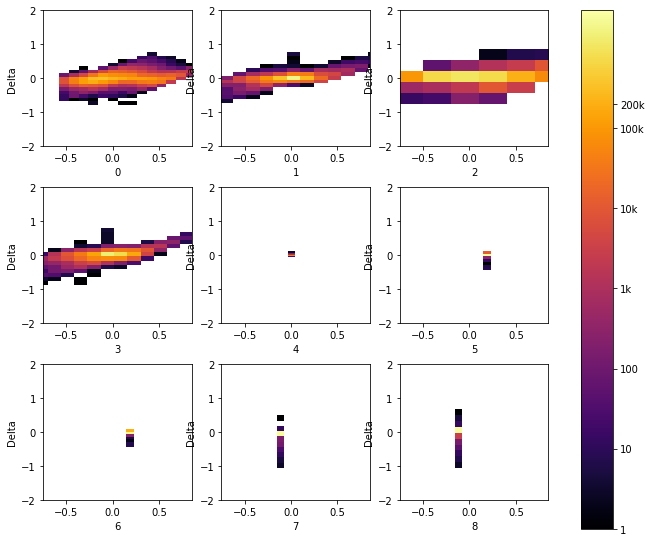

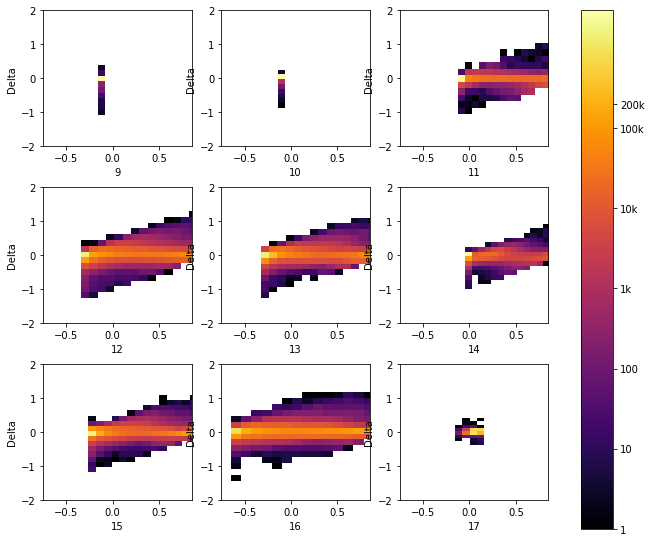

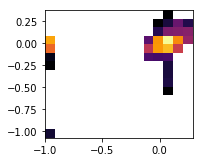

In [37]:
# The plots below show the difference between predictions to true scaled feature values 
# as a function of the true feature value. The closer the histograms are centered
# around the line y=0, the better the autoencoder has performed

l_minmax = [[-2, 2]] * 18 # The y limits
for encoding_dim in save_decoded_dict:
#for encoding_dim in [1]:
    plot_difference_displ(
        TYPE, pd.DataFrame(save_decoded_dict[encoding_dim]), pd.DataFrame(test_input), 
        encoding_dim, Transform=False, SetMinMax=True, FTS_SCLD=True, l_minmax=l_minmax
    )

Распределения значений фич до и после автоэнкодера

In [33]:
for encoding_dim in tqdm(l_encoding_dim):
    # save decoded
    df_temp_dec = pd.DataFrame(save_decoded_dict_dec[encoding_dim], columns=vars_list_input)
    df_temp_full_dec = pd.DataFrame(np.concatenate([df_temp_dec, df[['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']].iloc[idx_test]], axis=1), columns=vars_list_input+['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0'])
    df_temp_full_dec.to_csv("df_full_decoded_ratio25_{}.csv".format(encoding_dim))
    
#     df_temp_enc = pd.DataFrame(save_encoded_dict[encoding_dim])
#     df_temp_full_enc = pd.DataFrame(np.concatenate([df_temp_enc, df[['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']].iloc[idx_test]], axis=1), columns=list(range(encoding_dim))+['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0'])
#     df_temp_full_enc.to_csv("df_full_encoded_ratio25_{}.csv".format(encoding_dim))


100%|██████████| 7/7 [19:29<00:00, 167.13s/it]


******************** 3 ********************


/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


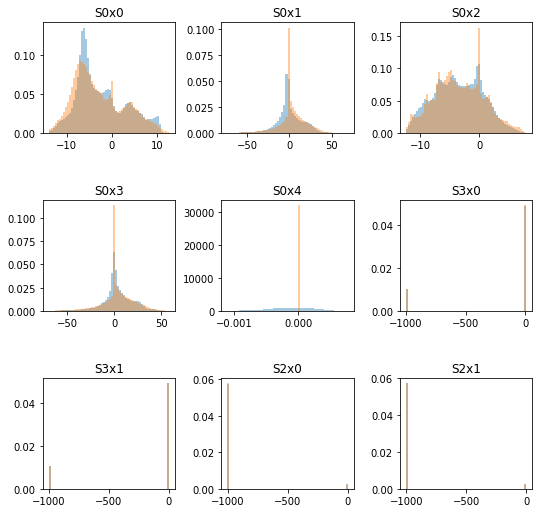

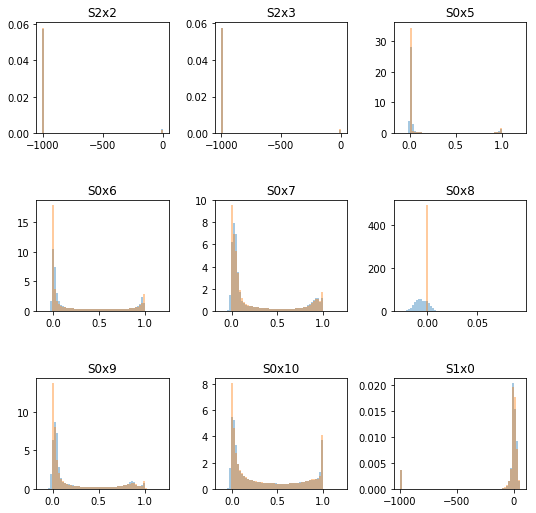

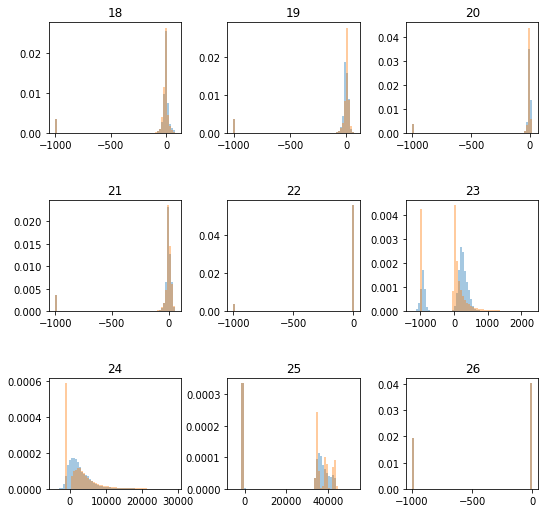

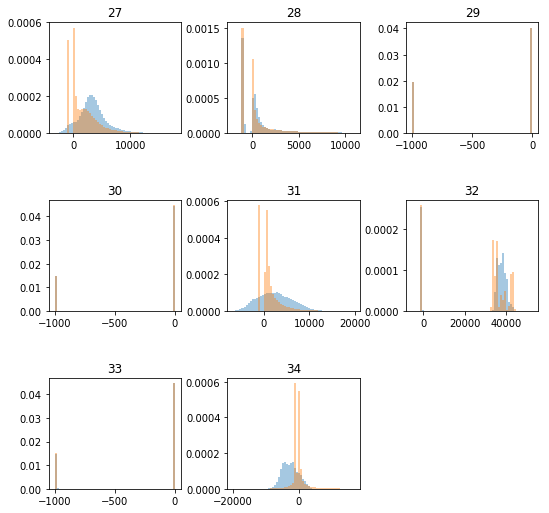

******************** 6 ********************


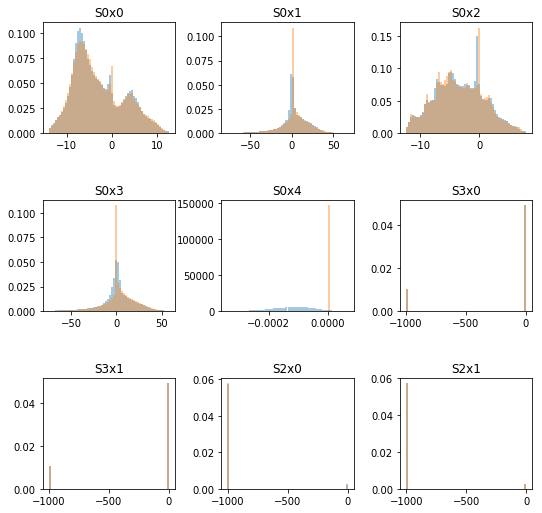

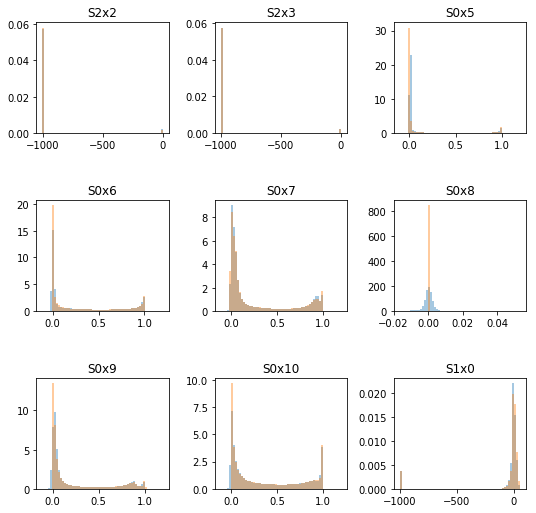

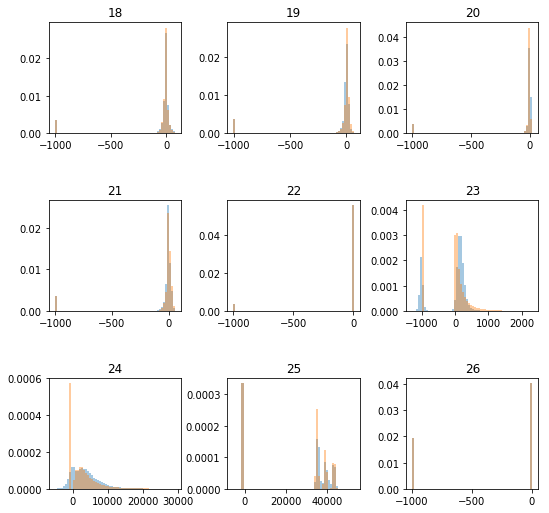

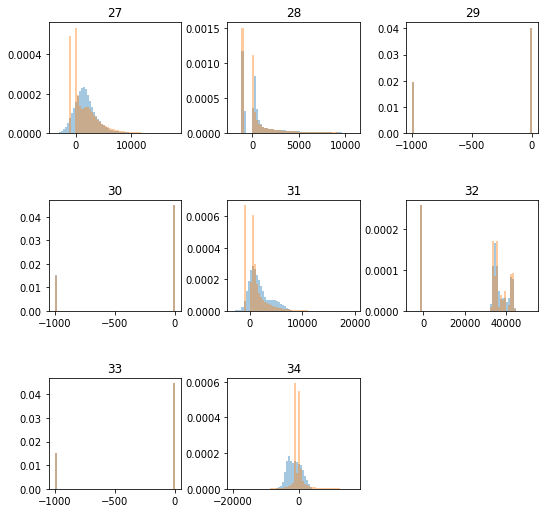

******************** 9 ********************


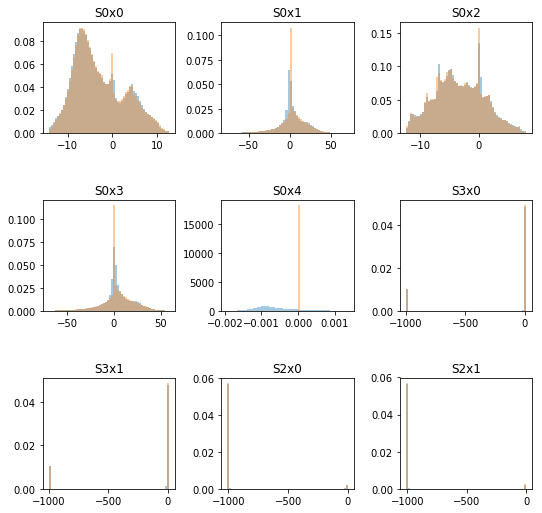

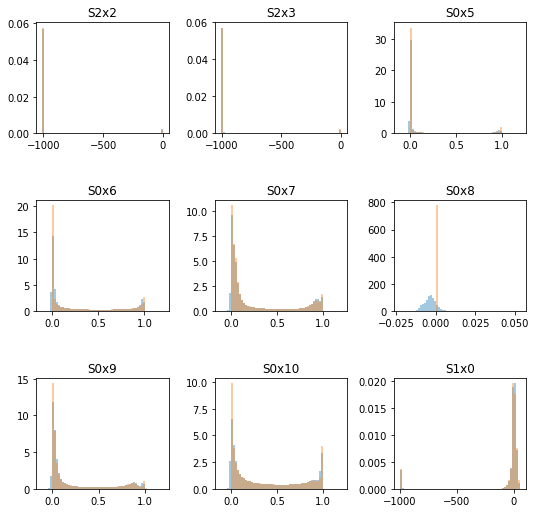

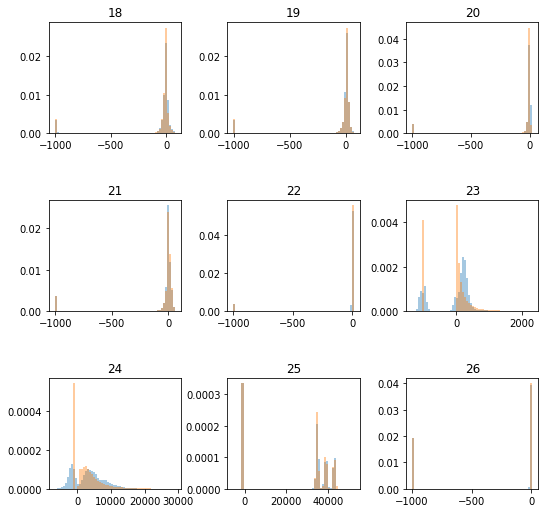

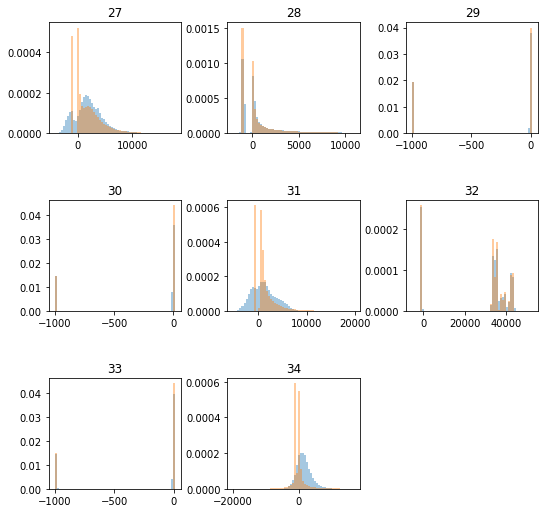

In [19]:
# The following plots show the orignal distributions in orange and the decoded distributions in blue.
# If the autoencoder has not lost a lot of information, these should lie on top of each other

rename_dict = {}
for i, e in enumerate(range(18)):
    rename_dict[e] = vars_list_input[i]
    
    
for encoding_dim in l_encoding_dim:
    # if you don't care about the names of the features uncomment the following line
#     print_features_histograms(
#         pd.DataFrame(save_decoded_dict_dec[encoding_dim]), 
#         target=pd.DataFrame(test_input_dec)
#     )
    print('*' * 20, encoding_dim, '*' * 20)
    
    df_temp = pd.DataFrame(save_decoded_dict_dec[encoding_dim])
    df_temp_input = pd.DataFrame(test_input_dec)

    df_temp.rename(columns=rename_dict, inplace=True)
    df_temp_input.rename(columns=rename_dict, inplace=True)

    print_features_histograms_displ(
        df_temp, target=df_temp_input, 
        save_filename="_{1}_orig_uncom_distribs_{0}.png".format(TYPE, encoding_dim)
    )
    plt.show()

Зависимость MSE от encoding_dim

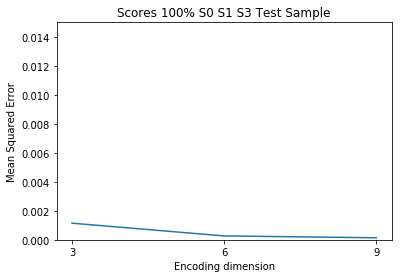

In [20]:
# Plotting the training loss (linear plot)
# The error stops decreasing dramatically after the encoding dimension is the number of independent variables.
plt.plot(l_encoding_dim, l_score)
plt.title("Scores 100% S0 S1 S3 Test Sample")
plt.xlabel("Encoding dimension")
plt.ylabel("Mean Squared Error")
plt.xticks(l_encoding_dim)
plt.ylim(0, max(l_score)*1.2)
plt.ylim(0, 0.015)
plt.savefig("./img/scores_{}.png".format(TYPE))

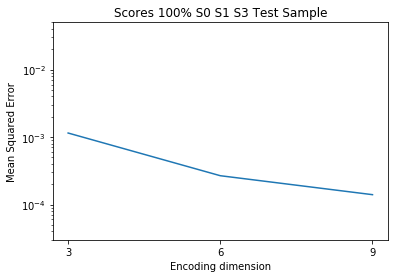

In [21]:
# Plotting the training loss (log plot)
# The error stops decreasing dramatically after the encoding dimension is the number of independent variables.
plt.semilogy(l_encoding_dim, l_score)
plt.title("Scores 100% S0 S1 S3 Test Sample")
plt.xlabel("Encoding dimension")
plt.ylabel("Mean Squared Error")
plt.xticks(l_encoding_dim)
#plt.ylim(0, max(l_score)*1.2)
plt.ylim(0.00003, 0.05)
plt.savefig("./img/scores_log_{}.png".format(TYPE))

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

# Тестирование автоэнкодера на задаче классификации

In [19]:
import os
import json
import shutil

In [20]:
import xgboost as xgb
from IPython import display
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score, accuracy_score

In [21]:
# Save
def _transform_val(v):
    if isinstance(v, dict):
        return {kk: list(vv) if isinstance(vv, np.ndarray) else vv 
                for kk, vv in v.items()}
    elif isinstance(v, np.ndarray):
        return list(v)
    else:
        return v
    
def dump(saved_dict, folder, name):
    """ Save a 'saved_dict' to .json in 'folder' with 'name'.
    
    Params
    ------
        saved_dict : dict, {'encoding_dim' : [metric_value, ...]} or 
                           {'pid_label' : {'encoding_dim' : [metric_value, ...]} }
            Dict of a metric. 
    """
    dict_for_json = {k: _transform_val(v) for k, v in saved_dict.items()}
    with open(os.path.join(folder, name + ".json"), 'w', encoding="utf-8") as file:
        # writing
        json.dump(dict_for_json, file, indent=4, ensure_ascii=False)
    del dict_for_json


def get_last_dir_n(path_to_metrics, metrics_dir_name):
    """ Return the highest number of folders which name == number"""
    try:
        last_folder_n = max(list(map(lambda name: int(name.split('_')[-1]), 
                                     filter(lambda name: os.path.isdir(os.path.join(path_to_metrics, name)) 
                                            and name.split('_')[-1].isdecimal(), os.listdir(path_to_metrics)))))
    except:
        last_folder_n = None
        
    return last_folder_n


def create_metrics_folder(path_to_metrics, metrics_dir_name):
    """ Create new folder for metrics in 'metrics_path' dir.
    Return
    ------
        new_folder : str
            Path to new folder.
        old_folder : str
            Path to prev folder.
    """
    last_folder_n = get_last_dir_n(path_to_metrics, metrics_dir_name)
    if last_folder_n is None:
        new_folder = os.path.join(path_to_metrics, metrics_dir_name + '_0')
        old_folder = None
    else:
        new_folder = os.path.join(path_to_metrics, metrics_dir_name + '_' + str(last_folder_n + 1))
        old_folder = os.path.join(path_to_metrics, metrics_dir_name + '_' + str(last_folder_n))
    os.makedirs(new_folder)
    
    return new_folder, old_folder


def dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict):
    """ Save all metrics from 'metrics_dict' to .json files.
        Save in 'path_to_metrics' + 'metrics_dir_name' + '_' + str(version) dir 
        to new folder and delete prev version.
        
    Params
    ------    
        metrics_dict : dict, {'metric_name' :  {'encoding_dim' : [metric_value, ...]}} or
                             {'metric_name' :  {'pid_label' : {'encoding_dim' : [metric_value, ...]} }}
            Dict of dicts for all metrics.
    """
    folder, old_folder = create_metrics_folder(path_to_metrics, metrics_dir_name)
    print(folder)

    for metric_name, metric_values in metrics_dict.items():
        dump(metric_values, folder, metric_name)
    
    if old_folder is not None:
        shutil.rmtree(old_folder, ignore_errors=True)

In [22]:
# Load
def load_metrics(path_to_metrics, metrics_dir_name):
    """
    Return
    ------    
        metrics_dict : dict, {'metric_name' :  {'encoding_dim' : [metric_value, ...]}} or
                             {'metric_name' :  {'pid_label' : {'encoding_dim' : [metric_value, ...]} }}
            Dict of dicts for all metrics.
    """
    metrics_dict = {}
    last_folder_n = get_last_dir_n(path_to_metrics, metrics_dir_name)
    folder = os.path.join(path_to_metrics, metrics_dir_name + '_' + str(last_folder_n))
    for file_name in filter(lambda name: name.endswith('.json'), os.listdir(folder)):
        with open(os.path.join(folder, file_name), 'r') as file:
            metrics_dict[file_name[:-5]] = json.load(file)
    return metrics_dict

In [23]:
def plot_roc_auc(fpr, tpr, roc_auc, f_measure, acc, pid_label=0, xlim=(0, 1), ylim=(0, 1),
                 title='Receiver operating characteristic'):
    plt.figure()
    lw = 2
    l_colors= ['darkorange', 'blue', 'red', 'green', 'black', 'yellow']
    for i, encoding_dim in enumerate(fpr.keys()):
        plt.plot(
            fpr[encoding_dim][pid_label], tpr[encoding_dim][pid_label], color=l_colors[i], lw=lw, 
            label="{} ROC AUC {:.3}, F {:.3}, Acc {:.3}".format(
                encoding_dim, roc_auc[encoding_dim][pid_label], 
                f_measure[encoding_dim], acc[encoding_dim]
            )
        )
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title(title)
    plt.savefig("./img/ROC_{}.png".format(TYPE))
    plt.show()

In [24]:
def plot_metrics(metrics_dict_, pid_label=0, xlim=(0, 1), ylim=(0, 1)):
    plt.figure(figsize=(15, 7))
    lw = 2
    l_colors= ['cyan', 'pink', 'grey', 'orange', 'darkorange', 'blue', 'red', 'green', 'black', 'yellow']
    # ROC AUC
    plt.subplot(1, 2, 1)
    for i, encoding_dim in enumerate(metrics_dict_['fpr'].keys()):
        if encoding_dim == "ololo":
            encoding_dim = "GAN"
        plt.plot(
            metrics_dict_['fpr'][encoding_dim][pid_label], metrics_dict_['tpr'][encoding_dim][pid_label], 
            color=l_colors[i], lw=lw, 
            label="{} ROC AUC {:.3}, F {:.3}, Acc {:.3}".format(
                encoding_dim, metrics_dict_['roc_auc'][encoding_dim][pid_label], 
                metrics_dict_['f_measure'][encoding_dim], metrics_dict_['acc'][encoding_dim]
            )
        )
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title("ROC AUC")
    plt.savefig("./img/ROC_{}_xlim_{}_ylim_{}.png".format(TYPE, xlim, ylim))
    
    # PR AUC
    plt.subplot(1, 2, 2)
    for i, encoding_dim in enumerate(metrics_dict_['precision'].keys()):
        if encoding_dim == "ololo":
            encoding_dim = "GAN"
        
        plt.plot(
            metrics_dict_['precision'][encoding_dim][pid_label], metrics_dict_['recall'][encoding_dim][pid_label], 
            color=l_colors[i], lw=lw, 
            label="{} PR AUC {:.3}, F {:.3}, Acc {:.3}".format(
                encoding_dim, metrics_dict_['pr_auc'][encoding_dim][pid_label], 
                metrics_dict_['f_measure'][encoding_dim], metrics_dict_['acc'][encoding_dim]
            )
        )
    plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(loc="lower left")
    plt.title("PR AUC")
    plt.savefig("./img/PR_{}_xlim_{}_ylim_{}.png".format(TYPE, xlim, ylim))
    plt.show()

In [25]:
le = LabelEncoder()
y = le.fit_transform(test_MC[:, 0])

In [26]:
test_input.shape, y.shape, test_MC.shape, test.shape

((13268755, 35), (13268755,), (13268755, 1), (13268755, 51))

In [27]:
test_input_x, y_x, test_MC_x, test_x = test_input.copy(), y.copy(), test_MC.copy(), test.copy()

In [28]:
save_encoded_dict = retain_dict['save_encoded_dict']

In [63]:
metrics_dict = {
    # ROC
    'fpr': defaultdict(dict),
    'tpr': defaultdict(dict),
    'roc_auc': defaultdict(dict),

    # PR
    'precision': defaultdict(dict), 
    'recall': defaultdict(dict),
    'pr_auc': defaultdict(dict),

    'f_measure': {},
    'acc': {}
}

In [64]:
test_input = test_input[:200000]
y = y[:200000]
test_MC = test_MC[:200000]

In [65]:
test_size = 0.3

idx_train_clf, idx_test_clf = train_test_split(np.arange(test_input.shape[0]), stratify=y, 
                                               random_state=42, test_size=test_size)
X_train, X_test = test_input[idx_train_clf], test_input[idx_test_clf]
y_train, y_test = y[idx_train_clf], y[idx_test_clf]

X_train_enc_dict, X_test_enc_dict = {}, {}
for encoding_dim in l_encoding_dim:
    X_train_enc_dict[encoding_dim] = save_encoded_dict[encoding_dim][idx_train_clf]
    X_test_enc_dict[encoding_dim] = save_encoded_dict[encoding_dim][idx_test_clf]

In [120]:
X_train_enc_dict[3].shape

(170000, 3)

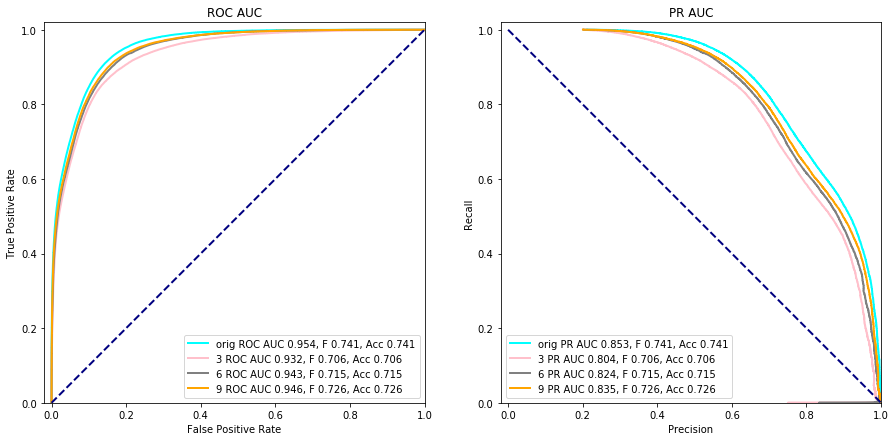

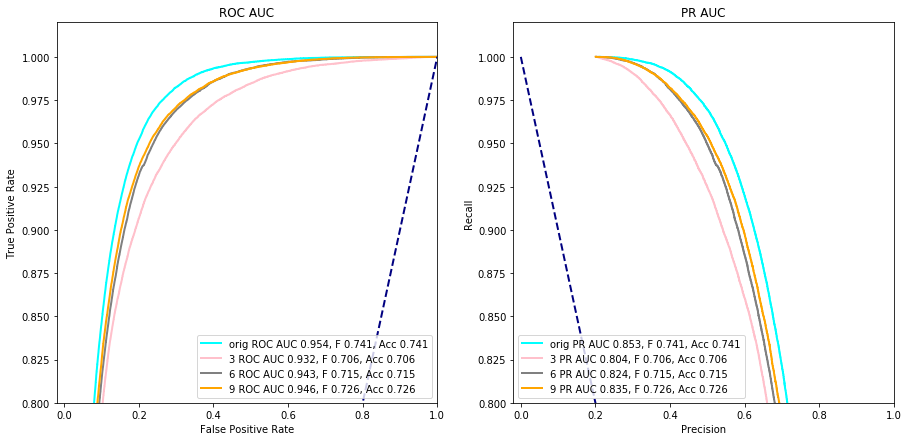

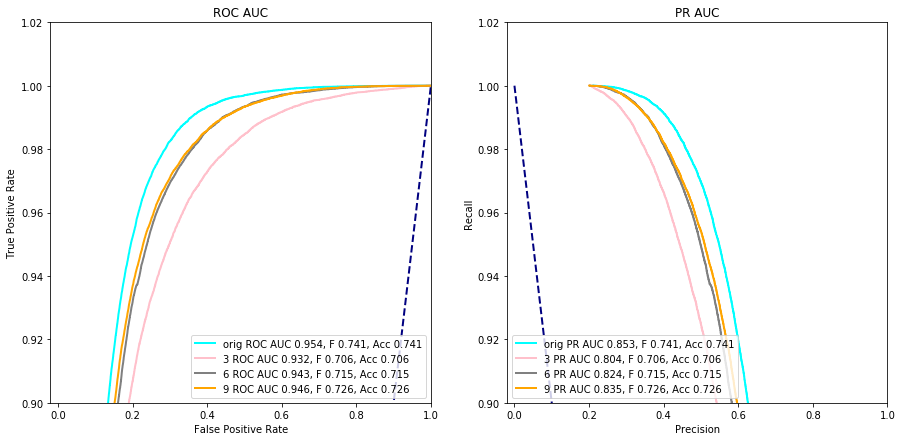














100%|██████████| 4/4 [04:28<00:00, 67.17s/it]














In [66]:
for encoding_dim in tqdm(["orig"] + l_encoding_dim):
    clf_name = "XGBoost_{}".format(encoding_dim)
    clf = xgb.XGBClassifier(nthread=-1, seed=111)
    
    if encoding_dim == "orig":
        clf.fit(X_train, y_train)
        y_proba = clf.predict_proba(X_test)
    else:
        clf.fit(X_train_enc_dict[encoding_dim], y_train)
        y_proba = clf.predict_proba(X_test_enc_dict[encoding_dim])
    y_pred = np.argmax(y_proba, axis=1)
    y_bin = label_binarize(y_test, classes=np.unique(y_test))
    
    # Compute ROC/PR curve and ROC/PR area for each class
    for pid_label in np.unique(y_test):
        idx = np.where(y_test == pid_label)[0]
        cur_y = np.where(y_test == pid_label, np.ones_like(y_test), np.zeros_like(y_test))
        cur_y_proba = y_proba[:, pid_label]
        
        pid_label = str(pid_label)
        metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], _ = \
            roc_curve(cur_y, cur_y_proba)
        metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], _ = \
            precision_recall_curve(cur_y, cur_y_proba)
        
    metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"], _ = \
        roc_curve(y_bin.ravel(), y_proba.ravel())
    metrics_dict['precision'][encoding_dim]["micro"], metrics_dict['recall'][encoding_dim]["micro"], _ = \
        precision_recall_curve(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['roc_auc'][encoding_dim]["micro"] = auc(
        metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"])
    metrics_dict['pr_auc'][encoding_dim]["micro"] = average_precision_score(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['f_measure'][encoding_dim] = f1_score(y_test, y_pred, average='micro')
    metrics_dict['acc'][encoding_dim] = accuracy_score(y_test, y_pred)
    
    # Save
    dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict)
    
    # Plot
    display.clear_output(wait=True)
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02))
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.8, 1.02))
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.9, 1.02))